In [96]:
import os
import nengo
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import nengo_dl
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, ShuffleSplit
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, Dropout, AveragePooling2D, Flatten, Dense

In [97]:
# global config
dataset_path = os.path.join('..', 'datasets', 'VarekaGTNEpochs.mat')
os.makedirs('nengo', exist_ok=True)
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [98]:
def get_dataset(file = dataset_path):
    """
    Helper function to get dataset from file
    """
    np_file = loadmat(file)
    target_data = np_file['allTargetData']
    non_target_data = np_file['allNonTargetData']

    features = np.concatenate((target_data, non_target_data))
    target_labels = np.tile(np.array([1, 0]), (target_data.shape[0], 1))
    non_target_labels = np.tile(np.array([0, 1]), (non_target_data.shape[0], 1))
    labels = np.vstack((target_labels, non_target_labels))

    threshold = 100.0
    result_x, result_y = [], []
    for i in range(features.shape[0]):
        if not np.max(np.abs(features[i])) > threshold:
            result_x.append(features[i])
            result_y.append(labels[i])

    features, labels = np.array(result_x), np.array(result_y)
    features = features.reshape((features.shape[0], 1, -1))
    labels = labels.reshape((labels.shape[0], 1, -1))
    print(features.shape)
    print(labels.shape)
    print(labels)

    print('parsed features and labels, features: {}, labels: {}'.format(features.shape, labels.shape))
    return features, labels

In [99]:
def create_model():
    """
    Function to create tensorflow model
    """
    input = Input(shape=(1200, 3, 1), name='input_layer')
    conv2d = Conv2D(filters=6, kernel_size=(3, 3), activation=keras.activations.relu)(input)
    dropout1 = Dropout(0.5, seed=0)(conv2d)
    avg_pooling = AveragePooling2D(pool_size=(1, 8), padding='same')(dropout1)
    flatten = Flatten()(avg_pooling)
    dense1 = Dense(100, activation=keras.activations.relu)(flatten)
    batch_norm = BatchNormalization()(dense1)
    dropout2 = Dropout(0.5, seed=0)(batch_norm)
    output = Dense(2, activation=keras.activations.softmax, name='output_layer')(dropout2)

    return Model(inputs=input, outputs=output)

In [100]:
def run_nengo_ann(train_x, train_y, valid_x, valid_y, test_x, test_y,
                  param_output=os.path.join('nengo', 'network_params')):
    """
    Runs ann network with nengo wrapper
    """
    model = create_model()
    converter = nengo_dl.Converter(model)

    early_stop = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)

    # run ann with nengo
    with nengo_dl.Simulator(converter.net, minibatch_size=16) as simulator:
        simulator.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        history = simulator.fit(x=train_x, y=train_y,
                                validation_data=(valid_x, valid_y),
                                epochs=30,
                                shuffle=True,  # delete later to see if it makes any difference
                                callbacks=[early_stop]
                                )

        ann_results = simulator.evaluate(x=test_x, y=test_y)
        simulator.save_params(param_output)

    return model, history, ann_results

def run_nengo_spiking(test_x, test_y, model, params=os.path.join('nengo', 'network_params'),
                      spiking_scaling=500, synapse=0.01, timesteps = 30):
    """
    Runs SNN as ANN parameter with SpikingRectifiedLinear() activation instead of elu
    """
    converter = nengo_dl.Converter(model=model,
                                   swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
                                   scale_firing_rates=spiking_scaling, synapse=synapse)

    with converter.net:
        nengo_dl.configure_settings(stateful=False)

    output_layer = converter.outputs[model.get_layer('output_layer')]

    time_tiled_x = np.tile(test_x, (1, timesteps, 1))

    with nengo_dl.Simulator(converter.net, minibatch_size=41, progress_bar=False) as simulator:
        simulator.load_params(params)
        predictions = simulator.predict(time_tiled_x)[output_layer]
        # slice all except for last timestep and get argmax of it
        predictions = predictions[:, timesteps-2, :]
        predictions = np.argmax(predictions, axis=-1)
        print(predictions, predictions.shape)

        test_y = np.squeeze(test_y, axis=1)
        test_y = np.argmax(test_y, axis=-1)
        print(test_y, test_y.shape)
        avg = (predictions == test_y).mean()

        return avg

In [101]:
# Driver code
features, labels = get_dataset()
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=.25, random_state=seed, shuffle=True)

print('train_x: {}, shape: {}, train_y: {}, shape: {}'.format(train_x, train_x.shape, train_y, train_y.shape))
print('test_x: {}, shape: {}, test_y: {}, shape: {}'.format(test_x, test_x.shape, test_y, test_y.shape))

valid, ann, snn = [], [], []

iter = 1
monte_carlo = ShuffleSplit(n_splits=1, test_size=.25, random_state=seed)

for train, validation in monte_carlo.split(train_x):

    print('iteration {}'.format(iter))
    print('train: {}, validation: {}'.format(train, validation))

    curr_train_x, curr_train_y = train_x[train], train_y[train]
    curr_valid_x, curr_valid_y = train_x[validation], train_y[validation]

    params_output = os.path.join('nengo','params_iter_{}'.format(iter))
    model, history, ann_eval = run_nengo_ann(
        train_x=curr_train_x, train_y=curr_train_y, valid_x=curr_valid_x, valid_y=curr_valid_y,
        test_x=test_x, test_y=test_y, param_output=params_output
    )
    print('{}. ann accuracy {:5f}%'.format(iter, ann_eval['probe_accuracy'] * 100))

    valid.append(history)
    ann.append(ann_eval)

    snn_eval = run_nengo_spiking(test_x=test_x, test_y=test_y, model=model, params=params_output)

    snn.append(snn_eval)
    print('{}. snn accuracy {:5f}%'.format(iter, snn_eval * 100))
    iter += 1

(8036, 1, 3600)
(8036, 1, 2)
[[[1 0]]

 [[1 0]]

 [[1 0]]

 ...

 [[0 1]]

 [[0 1]]

 [[0 1]]]
parsed features and labels, features: (8036, 1, 3600), labels: (8036, 1, 2)
train_x: [[[ -0.5420959   -1.21452522  -1.89456093 ...  -1.16598654  -1.73066759
    -2.2462945 ]]

 [[ -9.35857487  -9.43084145  -9.40663052 ...  -1.80052102  -0.70815951
     0.17630903]]

 [[  4.39046383   3.40499306   2.36262703 ...  38.03783417  38.5178566
    38.89231491]]

 ...

 [[-19.15268135 -19.42535782 -19.74151993 ... -18.02782631 -18.95302963
   -19.84547424]]

 [[ -6.18331957  -6.31638765  -6.51171541 ...  -2.18290114  -0.5134446
     1.11941528]]

 [[ -1.88119197  -1.94168174  -2.00751877 ...  16.48749733  16.58769226
    16.59143066]]], shape: (6027, 1, 3600), train_y: [[[0 1]]

 [[1 0]]

 [[0 1]]

 ...

 [[1 0]]

 [[1 0]]

 [[1 0]]], shape: (6027, 1, 2)
test_x: [[[-10.23770618  -9.63037395  -8.99108791 ... -28.15560532 -28.65115166
   -29.07019806]]

 [[ -3.7638278   -3.64355755  -3.53627396 ...  12.

c:\users\itznu\anaconda3\envs\tensorflow-gpu\lib\site-packages\nengo_dl\converter.py:325: UserWarning: Layer type <class 'tensorflow.python.keras.layers.core.Dropout'> does not have a registered converter. Falling back to TensorNode.
  warnings.warn(
c:\users\itznu\anaconda3\envs\tensorflow-gpu\lib\site-packages\nengo_dl\converter.py:325: UserWarning: average_pooling2d_29.padding has value same != valid, which is not supported. Falling back to TensorNode.
  warnings.warn(
c:\users\itznu\anaconda3\envs\tensorflow-gpu\lib\site-packages\nengo_dl\converter.py:325: UserWarning: Cannot convert BatchNormalization layer to native Nengo objects unless inference_only=True or layer.trainable=False. Falling back to TensorNode.
  warnings.warn(
c:\users\itznu\anaconda3\envs\tensorflow-gpu\lib\site-packages\nengo_dl\converter.py:589: UserWarning: Activation type <function softmax at 0x000001872C218B80> does not have a native Nengo equivalent; falling back to a TensorNode
  warnings.warn(
c:\users\it

TypeError: cannot unpack non-iterable AxesSubplot object

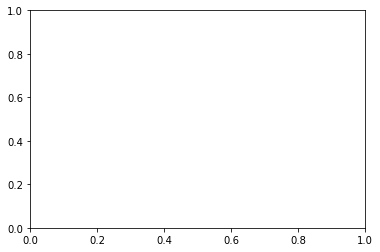

In [102]:
# Visualize using bar graph

def visualize(ann_eval, snn_eval):
    fig = plt.figure()

    average_ann, average_snn = [], snn_eval
    for eval in ann_eval:
        average_ann.append(eval['probe_accuracy'])

    fig, ax = plt.subplot()
    index = np.arange(len(average_ann))

    bar_width = 0.1
    ann_bars = plt.bar(index, average_ann, bar_width, color='palegoldenrod', label='ANN')
    snn_bars = plt.bar(index + bar_width, average_snn, bar_width, color='cornflowerblue', label='SNN')
    plt.xlabel('Model accuracy')
    plt.ylabel('Iteration')
    plt.title('Average test accuracy per Shuffle and Split iteration')
    plt.legend()
    plt.tight_layout()

    plt.show()

visualize(ann, snn)

In [ ]:
a = np.array([[0.2,0.8,15], [99,0.1,2.23], [0.01, 1000.99,342.0]])
b = np.array([[1,0,0], [1,0,0], [0, 1,0]])
a_argmax = np.argmax(a, axis=-1)
b_argmax = np.argmax(b, axis=-1)
print(a_argmax, b_argmax, (a_argmax==b_argmax).mean())